In [2]:
import time
import warnings
import numpy as np
from numpy.random import choice, dirichlet, randint, normal, rand
from numpy.linalg import eig, svd, qr, norm
from scipy.stats import entropy
from scipy.linalg import pinv
from scipy.spatial.distance import cdist
from scipy.interpolate import interpn, LinearNDInterpolator, RBFInterpolator
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.preprocessing import normalize
from tensorflow.keras.datasets import mnist

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

import tensorly as tl
from tensorly.decomposition import power_iteration, parafac_power_iteration

In [3]:
def SketchyCoreSVD(A,r,m,n):
    sampled_row = choice(A.shape[0],m,replace=False)
    sampled_col = choice(A.shape[1],n,replace=False)
    
    km = int(r + (m-r)/3)
    sm = int(r + 2*(m-r)/3)
    kn = int(r + (n-r)/3)
    sn = int(r + 2*(n-r)/3)

    Map = normal(size=(km,m))
    Map_T = normal(size=(n,kn))
    MapL = normal(size=(sm,m))
    MapR = normal(size=(sn,n))

    X = Map @ A[list(sampled_row),:]
    Y = A[:,list(sampled_col)] @ Map_T
    Z = MapL @ A[np.meshgrid(list(sampled_row), list(sampled_col), indexing='ij')[0],np.meshgrid(list(sampled_row), list(sampled_col), indexing='ij')[1]] @ MapR.T

    P, R1 = qr(np.array(X.T))
    Q, R2 = qr(np.array(Y))

    C = pinv(MapL @ Q[list(sampled_row),:]).dot(Z).dot(pinv(MapR @ P[list(sampled_col),:]).T)
    Ahat = Q.dot(C).dot(P.T)
    return norm(A - Ahat)**2 / norm(A)**2

# load MNIST dataset

In [4]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
A = X_train[:1000].reshape(1000,28*28) / 255.
N = A.shape

In [5]:
N

(1000, 784)

In [118]:
def SVD_rank(A):
    # matrix unfoldings
    A1 = A
    A2 = A.T
    
    U1, s1, V1 = svd(A1,full_matrices=False)
    U2, s2, V2 = svd(A2,full_matrices=False)
    
    scree1 = []
    scree2 = []
    for r in range(s1.shape[0]):
        print(r,end='\r')
        scree1.append(norm(s1[r+1:])**2 / norm(A1)**2)
        if norm(s1[r+1:])**2 / norm(A1)**2 < 1e-7 :
                break
    for r in range(s2.shape[0]):
        print(r,end='\r')
        scree2.append(norm(s2[r+1:])**2 / norm(A2)**2)
        if norm(s2[r+1:])**2 / norm(A2)**2 < 1e-7 :
                break
                
    return [scree1, scree2]

In [119]:
scree = SVD_rank(A)

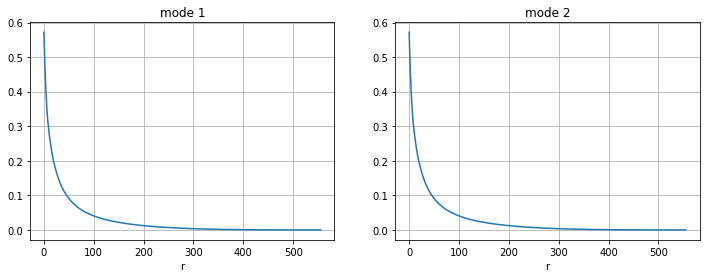

In [286]:
fig,ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(scree[0])
ax[0].set_title('mode 1')
ax[0].set_xlabel('r')
ax[0].grid()

ax[1].plot(scree[1])
ax[1].set_title('mode 2')
ax[1].set_xlabel('r')
ax[1].grid()
plt.show()

In [120]:
U,S,Vh = svd(A,full_matrices=False)

In [121]:
Ahat = np.dot(U[:, :100] * S[:100], Vh[:100,:])

In [122]:
norm(A - Ahat)**2 / norm(A)**2

0.04263357443519009

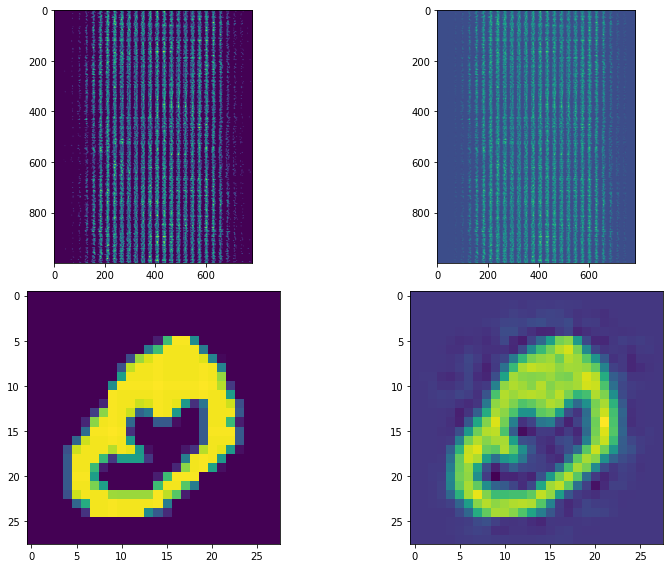

In [123]:
fig, ax = plt.subplots(2,2,figsize=[12,8])
ax[0,0].imshow(A)
ax[0,1].imshow(Ahat)
ax[1,0].imshow(A[63].reshape(28,28))
ax[1,1].imshow(Ahat[63].reshape(28,28))
plt.tight_layout()
plt.show()

# Baseline Full sample/feature GMM

In [101]:
gmm_full_row = GaussianMixture(n_components=30).fit(A)

In [102]:
gmm_full_row.n_iter_

2

In [105]:
memberships_full_row = gmm_full_row.predict(A)
cluster_match_full = {i: np.bincount(Y_train[:A.shape[0]][memberships_full_row == i]).argmax() for i in range(30)}
y_estimate_full = [cluster_match_full[i] for i in memberships_full_row]
np.sum(y_estimate_full == Y_train[:A.shape[0]])/A.shape[0]

0.76

In [134]:
gmm_full_col = GaussianMixture(n_components=6).fit(A.T)

In [139]:
memberships_full_col = gmm_full_col.predict(A.T)
memberships_count_full_col = np.unique(memberships_full_col,return_counts=True)
sad_full_col = np.sum(np.abs(np.diff(A,axis=0)),0)

In [140]:
avg_sad_full_col = []
entropy_sad_full_col = []
for i in range(6):
    if np.sum(memberships_full_col == i) > 1 and np.sum(sad_full_col[memberships_full_col == i]) > 0:
        avg_sad_full_col.append(np.mean(sad_full_col[memberships_full_col == i]))
        entropy_sad_full_col.append(entropy(sad_full_col[memberships_full_col == i]))
    else:
        avg_sad_full_col.append(0)
        entropy_sad_full_col.append(0.001)

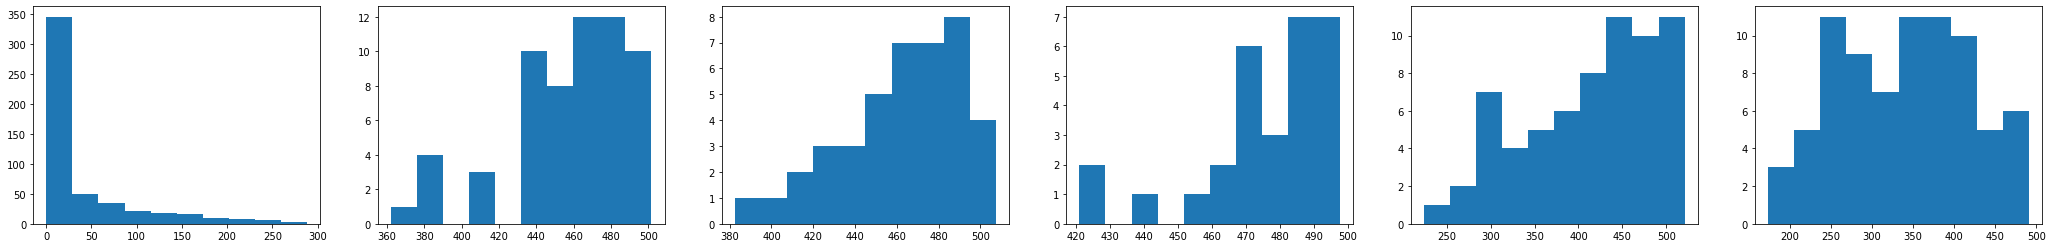

(array([0, 1, 2, 3, 4, 5], dtype=int64), array([511,  60,  41,  29,  65,  78], dtype=int64))
[5.16541083712933, 4.091827274902197, 3.7115119622908574, 3.366479524029265, 4.156742930293061, 4.329005862757604]
[36.78081424350565, 458.9265359477131, 462.1428981348644, 475.6442190669378, 413.44754147813046, 340.04801407742633]


In [142]:
fig, ax = plt.subplots(1,6,figsize=[36,4])
for i in range(6):
    ax[i].hist(sad_full_col[memberships_full_col == i])
plt.show()
print(memberships_count_full_col)
print(entropy_sad_full_col)
print(avg_sad_full_col)

# ProgressiveSketchingGMM

In [25]:
%%time
k = [20,6]
b = 100
r = 100
gmm_max_iter = 10
num_of_iter = 10

samplenum_log = []
Ahat_log = []
err_log = []
rnd_Ahat_log = []
rnd_err_log = []
for _ in range(20):
    sampled_row = set()
    unsampled_row = set(np.arange(N[0]))
    sampled_col = set()
    unsampled_col = set(np.arange(N[1]))
    memberships_row = choice(range(k[0]),N[0])
    memberships_col = choice(range(k[1]),N[1])
    delta_row = np.full((k[0],),int(b/np.sum(k)))
    delta_col = np.full((k[1],),int(b/np.sum(k)))

    for iter_index in range(1,num_of_iter):
        # sample new rows
        add_row = []
        for i in range(k[0]):
            if (len(np.where(memberships_row[sorted(unsampled_row)] == i)[0]) != 0) & (delta_row[i] > 0):
                if len(np.where(memberships_row[sorted(unsampled_row)] == i)[0]) <= delta_row[i]:
                    add_row.append(np.array(sorted(unsampled_row))[np.where(memberships_row[sorted(unsampled_row)] == i)[0]])
                else:
                    add_row.append(choice(np.array(sorted(unsampled_row))[np.where(memberships_row[sorted(unsampled_row)] == i)[0]],delta_row[i],replace=False)) 
        if len(add_row) > 0 :
            new_row = np.concatenate(add_row)
            sampled_row.update(new_row)
            unsampled_row = unsampled_row - set(new_row)
        samples_row = A[sorted(sampled_row)]

        # sample new cols
        add_col = []
        for i in range(k[1]):
            if (len(np.where(memberships_col[sorted(unsampled_col)] == i)[0]) != 0) & (delta_col[i] > 0):
                if len(np.where(memberships_col[sorted(unsampled_col)] == i)[0]) <= delta_col[i]:
                       add_col.append(np.array(sorted(unsampled_col))[np.where(memberships_col[sorted(unsampled_col)] == i)[0]])
                else:
                       add_col.append(choice(np.array(sorted(unsampled_col))[np.where(memberships_col[sorted(unsampled_col)] == i)[0]],delta_col[i],replace=False))
        if len(add_col) > 0:
            new_col = np.concatenate(add_col)
            sampled_col.update(new_col)
            unsampled_col = unsampled_col - set(new_col)
        samples_col = A.T[sorted(sampled_col)]

        # projection
        gmm_row = GaussianMixture(n_components=k[0],max_iter=gmm_max_iter,init_params='random_from_data').fit(samples_col.T)           
        memberships_row = gmm_row.predict(samples_col.T)
        memberships_count_row = np.unique(memberships_row,return_counts=True)

        # fit dpgmm_col and update number of col clusters
        gmm_col = GaussianMixture(n_components=k[1],max_iter=gmm_max_iter,init_params='random_from_data').fit(samples_row.T)           
        memberships_col = gmm_col.predict(samples_row.T)
        memberships_count_col = np.unique(memberships_col,return_counts=True)

        #SAD calculation
        #sad_row = np.sum(np.abs(np.diff(samples_col,axis=0)),0)
        #sad_col = np.sum(np.abs(np.diff(samples_row,axis=0)),0)
        sad_row = np.var(samples_col,axis=0)
        sad_col = np.var(samples_row,axis=0)
        entropy_sad_row = []
        entropy_sad_col = []
        for i in range(k[0]):
            if np.sum(memberships_row == i) > 1 and np.sum(sad_row[memberships_row == i]) > 0:
                entropy_sad_row.append(entropy(sad_row[memberships_row == i]))
            else:
                entropy_sad_row.append(0.001)
        for i in range(k[1]):
            if np.sum(memberships_col == i) > 1 and np.sum(sad_col[memberships_col == i]) > 0:
                entropy_sad_col.append(entropy(sad_col[memberships_col == i]))
            else:
                entropy_sad_col.append(0.001)   
        entropy_sad_row = np.array(entropy_sad_row)
        entropy_sad_col = np.array(entropy_sad_col)
        entropy_sad_row[np.where(entropy_sad_row == 0)] = 0.001
        entropy_sad_col[np.where(entropy_sad_col == 0)] = 0.001

        delta = np.array(dirichlet(np.append(entropy_sad_row,entropy_sad_col),1)[0] * b,dtype=int)
        delta_row = delta[:k[0]]
        delta_col = delta[k[0]:]

        #SketchyCoreSVD
        m = len(sampled_row)
        n = len(sampled_col)
        #if min(m,n) > r:
        if iter_index == num_of_iter-1:
            km = int(r + (m-r)/3)
            sm = int(r + 2*(m-r)/3)
            kn = int(r + (n-r)/3)
            sn = int(r + 2*(n-r)/3)
            
            rnd_sampled_row = choice(N[0],m,replace=False)
            rnd_sampled_col = choice(N[1],n,replace=False)

            Map = normal(size=(km,m))
            Map_T = normal(size=(n,kn))
            MapL = normal(size=(sm,m))
            MapR = normal(size=(sn,n))

            X = Map @ A[sorted(sampled_row),:]
            Y = A[:,sorted(sampled_col)] @ Map_T
            Z = MapL @ A[np.meshgrid(sorted(sampled_row), sorted(sampled_col), indexing='ij')[0],np.meshgrid(sorted(sampled_row), sorted(sampled_col), indexing='ij')[1]] @ MapR.T
            P, R1 = qr(np.array(X.T))
            Q, R2 = qr(np.array(Y))
            C = pinv(MapL @ Q[sorted(sampled_row),:]).dot(Z).dot(pinv(MapR @ P[sorted(sampled_col),:]).T)
            Ahat = Q.dot(C).dot(P.T)
            
            Ahat_log.append(Ahat[63])
            err_log.append(norm(A - Ahat)**2 / norm(A)**2)
            samplenum_log.append([m,n])
            
            X = Map @ A[sorted(rnd_sampled_row),:]
            Y = A[:,sorted(rnd_sampled_col)] @ Map_T
            Z = MapL @ A[np.meshgrid(sorted(rnd_sampled_row), sorted(rnd_sampled_col), indexing='ij')[0],np.meshgrid(sorted(rnd_sampled_row), sorted(rnd_sampled_col), indexing='ij')[1]] @ MapR.T
            P, R1 = qr(np.array(X.T))
            Q, R2 = qr(np.array(Y))
            C = pinv(MapL @ Q[sorted(rnd_sampled_row),:]).dot(Z).dot(pinv(MapR @ P[sorted(rnd_sampled_col),:]).T)
            Ahat = Q.dot(C).dot(P.T)
            
            rnd_Ahat_log.append(Ahat[63])
            rnd_err_log.append(norm(A - Ahat)**2 / norm(A)**2)
            #break
            #print(iter_index, len(sampled_row), len(sampled_col), norm(A - Ahat)**2 / norm(A)**2)
        #else:
            #print(iter_index, len(sampled_row), len(sampled_col))

Wall time: 2min 49s


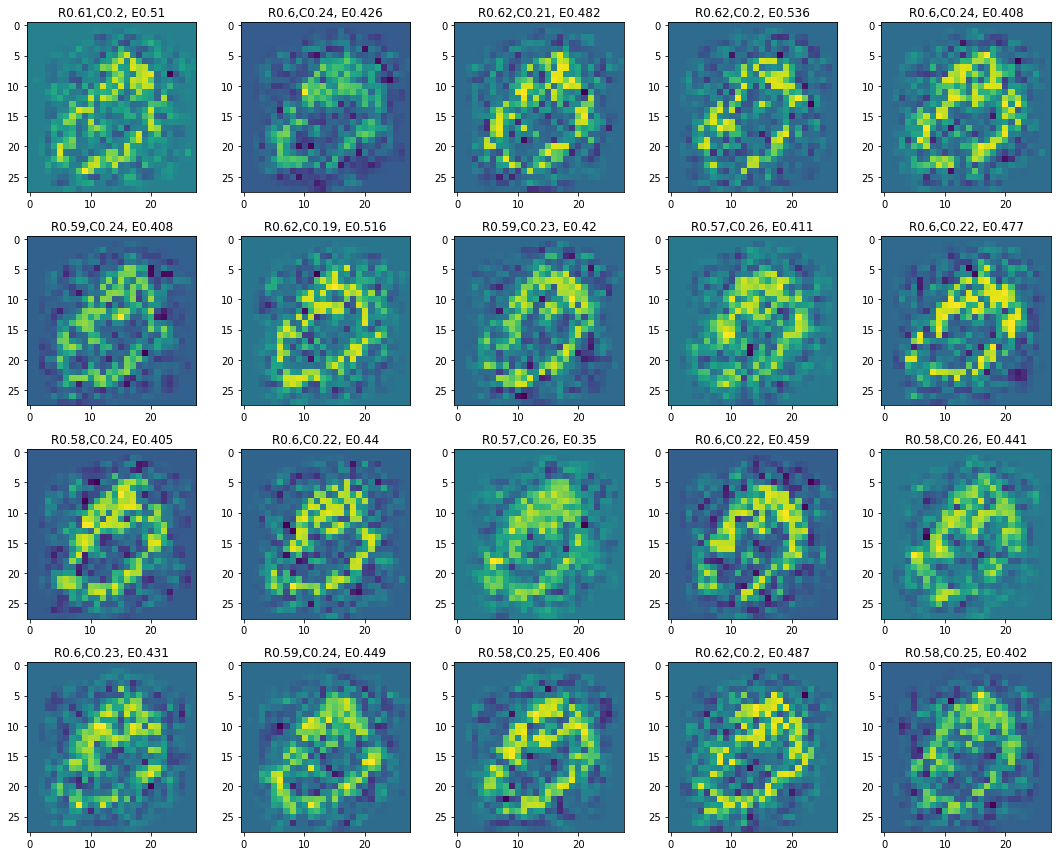

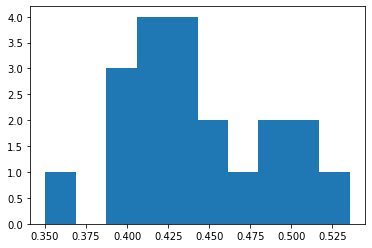

0.4431293127242655


In [26]:
fig, ax = plt.subplots(4,5,figsize=[15,12])
for img, axis, snum, err in zip(Ahat_log,ax.ravel(),samplenum_log,err_log):
    axis.imshow(img.reshape(28,28))
    axis.set_title(f'R{np.round(snum[0]/N[0],2)},C{np.round(snum[1]/N[1],2)}, E{np.round(err,3)}')
plt.tight_layout()
plt.show()

plt.hist(err_log)
plt.show()

print(np.mean(err_log))

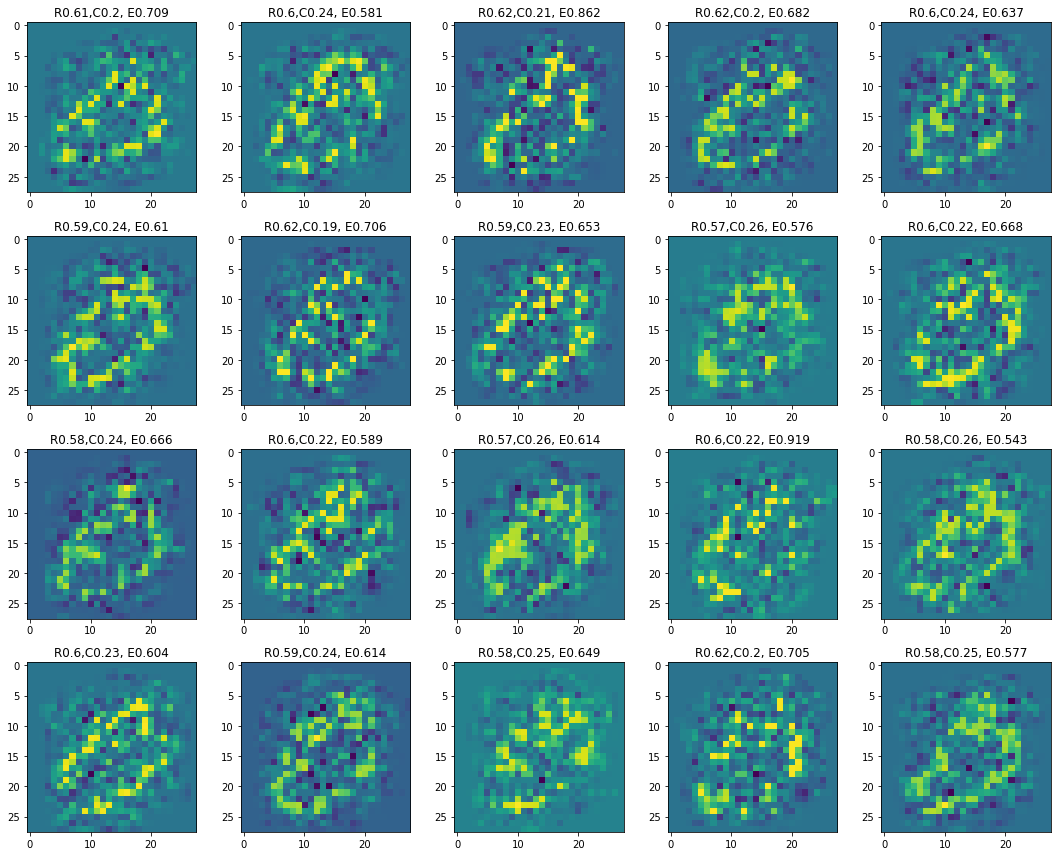

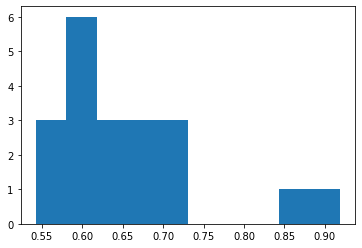

0.6582256548747957


In [27]:
fig, ax = plt.subplots(4,5,figsize=[15,12])
for img, axis, snum, err in zip(rnd_Ahat_log,ax.ravel(),samplenum_log,rnd_err_log):
    axis.imshow(img.reshape(28,28))
    axis.set_title(f'R{np.round(snum[0]/N[0],2)},C{np.round(snum[1]/N[1],2)}, E{np.round(err,3)}')
plt.tight_layout()
plt.show()

plt.hist(rnd_err_log)
plt.show()

print(np.mean(rnd_err_log))

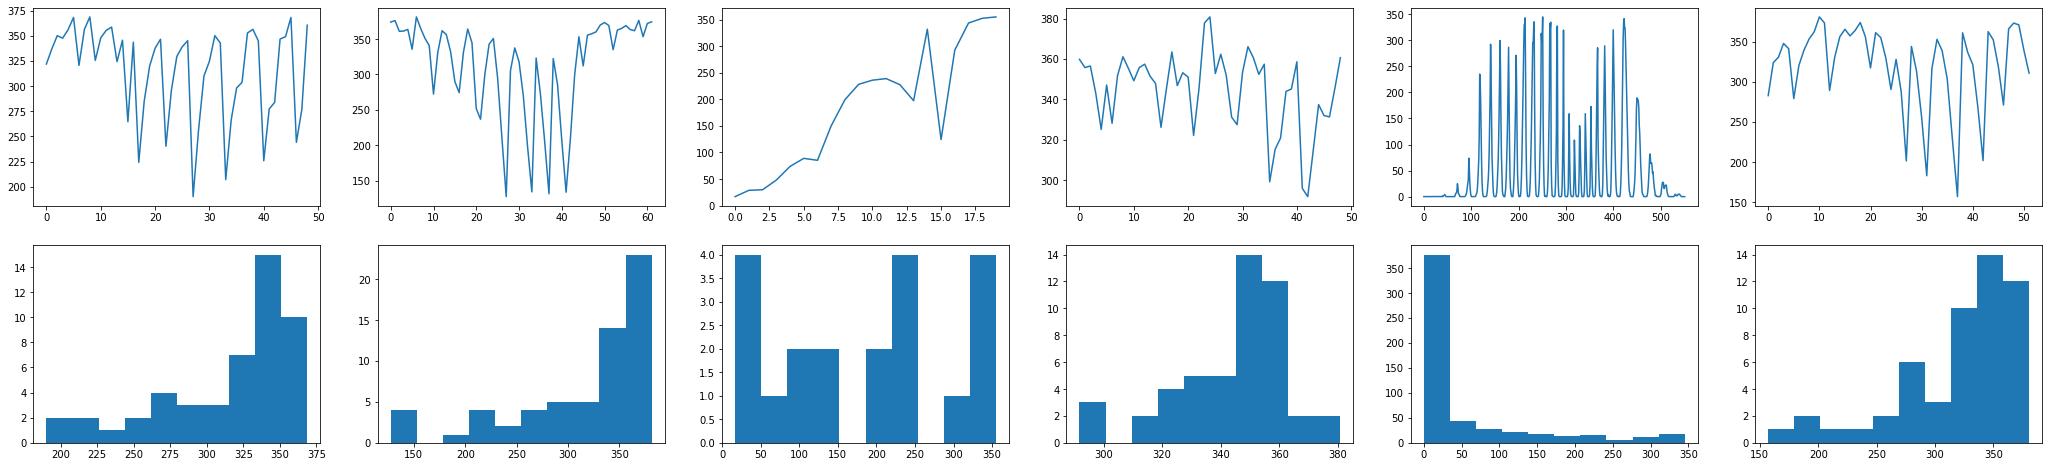

(array([0, 1, 2, 3, 4, 5], dtype=int64), array([ 49,  62,  20,  49, 552,  52], dtype=int64))
[3.88061847 4.09991459 2.77658145 3.89023923 5.21298271 3.93708416]
[316.16158463 313.21442125 182.34823529 344.14517807  51.76729895
 319.97730015]


In [148]:
fig, ax = plt.subplots(2,6,figsize=[36,8])
for i in range(6):
    ax[0,i].plot(sad_col[memberships_col == i])
    ax[1,i].hist(sad_col[memberships_col == i])
plt.show()
print(memberships_count_col)
print(entropy_sad_col)
print(avg_sad_col)

In [154]:
[SketchyCoreSVD(A,100,325,105) for i in range(10)]

[0.7440003855043656,
 0.7371029455329172,
 3.9351623072818245,
 1.120665019413082,
 0.777271269531628,
 0.7664933000188415,
 0.7805800182173791,
 0.9023064211254578,
 0.8901863808259322,
 0.8021562716078761]

## random sampling baseline

In [ ]:
r = 300
b = 60
err_A = []
err_U = []
err_V = []
for iter_index in range(10,25):
    sampled_row = choice(N[0],int(b*iter_index/2),replace=False)
    sampled_col = choice(N[1],int(b*iter_index/2),replace=False)
    
    m = int(b*iter_index/2)    
    k = int(r + (m-r)/3)
    s = int(r + 2*(m-r)/3)
    
    Map = normal(size=(k,m))
    Map_T = normal(size=(m,k))
    MapL = normal(size=(s,m))
    MapR = normal(size=(s,m))

    X = Map @ A[list(sampled_row),:]
    Y = A[:,list(sampled_col)] @ Map_T
    delta, theta = np.meshgrid(list(sampled_row), list(sampled_col), indexing='ij')
    Z = MapL @ A[delta,theta] @ MapR.T

    P, R1 = qr(np.array(X.T))
    Q, R2 = qr(np.array(Y))

    C = pinv(MapL @ Q[list(sampled_row),:]).dot(Z).dot(pinv(MapR @ P[list(sampled_col),:]).T)
    Ahat = Q.dot(C).dot(P.T)
    err_A.append(norm(A - Ahat)**2 / norm(A)**2)
err_A = np.array(err_A)

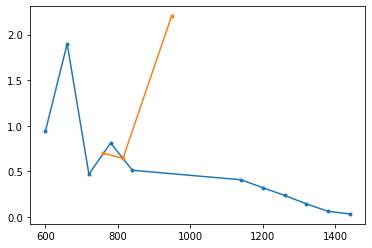

In [ ]:
fig, ax = plt.subplots(1,1,figsize=[6,4])
ax.plot(b*np.arange(10,25)[err_A<3],err_A[err_A<3],'.-')
ax.plot(sample_num_model[err_model<3],err_model[err_model<3],'.-')
plt.show()

In [ ]:
r = 300
k = 300
s = 300
Map = normal(size=(k,len(list(sampled_row))))
Map_T = normal(size=(len(list(sampled_col)),k))
MapL = normal(size=(s,len(list(sampled_row))))
MapR = normal(size=(s,len(list(sampled_col))))

X = Map @ A[list(sampled_row),:]
Y = A[:,list(sampled_col)] @ Map_T
delta, theta = np.meshgrid(list(sampled_row), list(sampled_col), indexing='ij')
Z = MapL @ A[delta,theta] @ MapR.T

P, R1 = qr(np.array(X.T))
Q, R2 = qr(np.array(Y))

C = pinv(MapL @ Q[list(sampled_row),:]).dot(Z).dot(pinv(MapR @ P[list(sampled_col),:]).T)
Ahat = Q.dot(C).dot(P.T)
err = norm(A - Ahat)**2 / norm(A)**2
mse = np.sum((A - Ahat)**2)/ A.size
psnr = 10 * np.log(np.max(A)**2 / mse)

In [ ]:
err

1.0332941802296796